In [ ]:

https://sci2lab.github.io/ml_tutorial/bert_farsi_sentiment/#BERT-Overview

https://www.youtube.com/watch?v=HqhnR1dVOK0

In [1]:
!pip install transformers==3

     |████████████████████████████████| 757kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 16.8MB/s 
     |████████████████████████████████| 3.0MB 35.1MB/s 
     |████████████████████████████████| 901kB 33.9MB/s 


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import csv
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BasicTokenizer
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample

In [ ]:
!pip freeze > requirements.txt

In [18]:
data_train = pd.read_csv('/content/Ben_fulltrain.csv')
data_train.head()

Unnamed: 0                                               Text  label
0           0  কবির সিংহ একেবারে জ্ঞানহীন সিনেমা .... এখানকার...      2
1           1  @ তরুন ভার্মা আপনি কোন মেয়েকে দেখেছেন যে আমি ...      2
2           2  কিছু লোক ভাল জিনিস পছন্দ করেন না তাদের সম্পর্ক...      2
3           3              ভাই আপনি এই প্রজন্মের একজন ত্রাণকর্তা      2
4           4  আমি নারীবাদী নই ... L n আমি লাস্ট স্টোরিগুলি ঘ...      2

In [19]:
data_test = pd.read_csv('/content/trac2_iben_dev.csv')

In [20]:
data_test.head()

ID  ... Sub-task B
0  C59.2078  ...       NGEN
1   C68.537  ...       NGEN
2  C59.1344  ...       NGEN
3   C59.706  ...        GEN
4   C68.663  ...       NGEN

[5 rows x 4 columns]

In [21]:
#data.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)




In [ ]:
#NAG_train = data[(data['Sub-task A']=='NAG')]
#OAG_train = data[(data['Sub-task A']=='CAG')]
#CAG_train = data[(data['Sub-task A']=='OAG')]

In [22]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [23]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 


OAG_test["Sub-task A"] = 1


CAG_test["Sub-task A"] = 2


#NAG_train.head()

In [ ]:
data_train = pd.concat([NAG_train,
                  OAG_train,
                  CAG_train
                 ],axis=0)

data_train.reset_index(inplace=True)

In [ ]:
data_train

index                                               Text  Sub-task A
0         0                                      Dada taratari           0
1         1                              Tumi korbe Amar sathe           0
2         4  পতিতাদের চরিত্র রাজনৈতিক নেতাদের থেকে হাজার গু...           0
3         5                                  Thik bolecho bhai           0
4         7                                             অমানুষ           0
...     ...                                                ...         ...
3821   3795                             Ora gushti sudho pagol           2
3822   3798  এরা সব এক একটা বেটিচোদ।\nএদের জন্য সমাজ নষ্ট হ...           2
3823   3808                                     মাদার চোদ রানু           2
3824   3814  @হিয়াশা জামান হীর orai amr maal khaa. Tate To...           2
3825   3820                                          বাল মন্ডল           2

[3826 rows x 3 columns]

In [24]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [25]:
#data_train = data_train.rename(columns = {'Sub-task A': 'label'}, inplace = False)
data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)


In [27]:
data_train

Unnamed: 0                                               Text  label
0              0  কবির সিংহ একেবারে জ্ঞানহীন সিনেমা .... এখানকার...      2
1              1  @ তরুন ভার্মা আপনি কোন মেয়েকে দেখেছেন যে আমি ...      2
2              2  কিছু লোক ভাল জিনিস পছন্দ করেন না তাদের সম্পর্ক...      2
3              3              ভাই আপনি এই প্রজন্মের একজন ত্রাণকর্তা      2
4              4  আমি নারীবাদী নই ... L n আমি লাস্ট স্টোরিগুলি ঘ...      2
...          ...                                                ...    ...
8076        7499                                 rani mondal ekta ։      2
8077        7500  যেইসব শযোর ঈদ এর দিন রেপ তাদের আবার আলাহ क सथ...      2
8078        7501             কততার মতো to খানকির মেযেকে বেযাদব and      2
8079        7502                                        baja maya ।      2
8080        7503                   ore magi tor a vikkha korte hobe      2

[8081 rows x 3 columns]

In [26]:
data_test

index                                               Text  label
0        0  Ek dom sothik kotha bolecho jhekane theka uthe...      0
1        2                                   DARUN AKDOM THIK      0
2        5                                    Kadam thik dada      0
3       12                               Supar bolla cho dada      0
4       15                                              Pagle      0
..     ...                                                ...    ...
952    935                         Vikari ranu tor gaan faltu      2
953    938                             Khanki magi ranu pagli      2
954    941                              কুকুরের বাচ্চা শালারা      2
955    948    জংলি হাতি,সব।বুর মাগির গুর দুধ জত পারিস তত চোদ।      2
956    950  @Habibul Sekh মোল্লা খানকির বাচ্চা মুখ সামলে ক...      2

[957 rows x 3 columns]

In [28]:
import logging
logging.basicConfig(level=logging.ERROR)

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

sample_txt = 'I am gay boy plese love me any hot top i love hot boys'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')


 Sentence: I am gay boy plese love me any hot top i love hot boys
   Tokens: ['I', 'am', 'gay', 'boy', 'pl', '##ese', 'love', 'me', 'any', 'hot', 'top', 'i', 'love', 'hot', 'boys']
Token IDs: [146, 10392, 29435, 26905, 20648, 13565, 16138, 10911, 11178, 29698, 12364, 177, 16138, 29698, 32647]


In [30]:
class_names = ['NAG', 'OAG', 'CAG']

In [31]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [32]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146, 10392, 29435, 26905, 20648, 13565, 16138, 10911, 11178,
        29698, 12364,   177, 16138, 29698, 32647,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [33]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [34]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [35]:
df_train, df_test = train_test_split(
  data_train,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [36]:
df_train.shape, df_val.shape, df_test.shape

((7272, 3), (404, 3), (405, 3))

In [37]:
MAX_LEN = 160

In [38]:
import logging
logging.basicConfig(level=logging.ERROR)

In [40]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [41]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [42]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [43]:
PRE_TRAINED_MODEL_NAME='bert-base-multilingual-cased'

In [44]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [46]:
last_hidden_state.shape
torch.Size([1, 32, 768])

torch.Size([1, 32, 768])

In [47]:
bert_model.config.hidden_size

768

In [48]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [49]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [50]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [51]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3570, 0.4026, 0.2404],
        [0.3975, 0.3353, 0.2671],
        [0.3810, 0.3146, 0.3044],
        [0.3763, 0.3775, 0.2462],
        [0.4393, 0.3332, 0.2276],
        [0.3567, 0.3845, 0.2588],
        [0.3973, 0.3346, 0.2681],
        [0.4839, 0.2683, 0.2478],
        [0.3948, 0.3512, 0.2539],
        [0.3761, 0.3500, 0.2739],
        [0.3741, 0.4004, 0.2256],
        [0.3362, 0.4228, 0.2410],
        [0.3359, 0.3597, 0.3044],
        [0.3713, 0.4116, 0.2171],
        [0.4048, 0.3261, 0.2690],
        [0.3398, 0.3861, 0.2741]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [52]:

EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/30
----------
Train loss 1.0284559885224143 accuracy 0.5173267326732673
Val   loss 1.0698492641632373 accuracy 0.4900990099009901

Epoch 2/30
----------
Train loss 1.0236467030022172 accuracy 0.5112761276127612
Val   loss 1.1336939632892609 accuracy 0.4900990099009901

Epoch 3/30
----------
Train loss 1.018183498461168 accuracy 0.5163641364136413
Val   loss 1.0938382698939397 accuracy 0.4900990099009901

Epoch 4/30
----------
Train loss 1.0114173842000438 accuracy 0.5207645764576457
Val   loss 1.1292090163781092 accuracy 0.4900990099009901

Epoch 5/30
----------
Train loss 1.0064622335381561 accuracy 0.5225522552255225
Val   loss 1.1288245297395265 accuracy 0.4900990099009901

Epoch 6/30
----------
Train loss 1.0083716975463615 accuracy 0.5184268426842684
Val   loss 1.101927053469878 accuracy 0.4900990099009901

Epoch 7/30
----------
Train loss 1.0057831233674353 accuracy 0.5228272827282728
Val   loss 1.1281304519910078 accuracy 0.4900990099009901

Epoch 8/30
----------
Train l

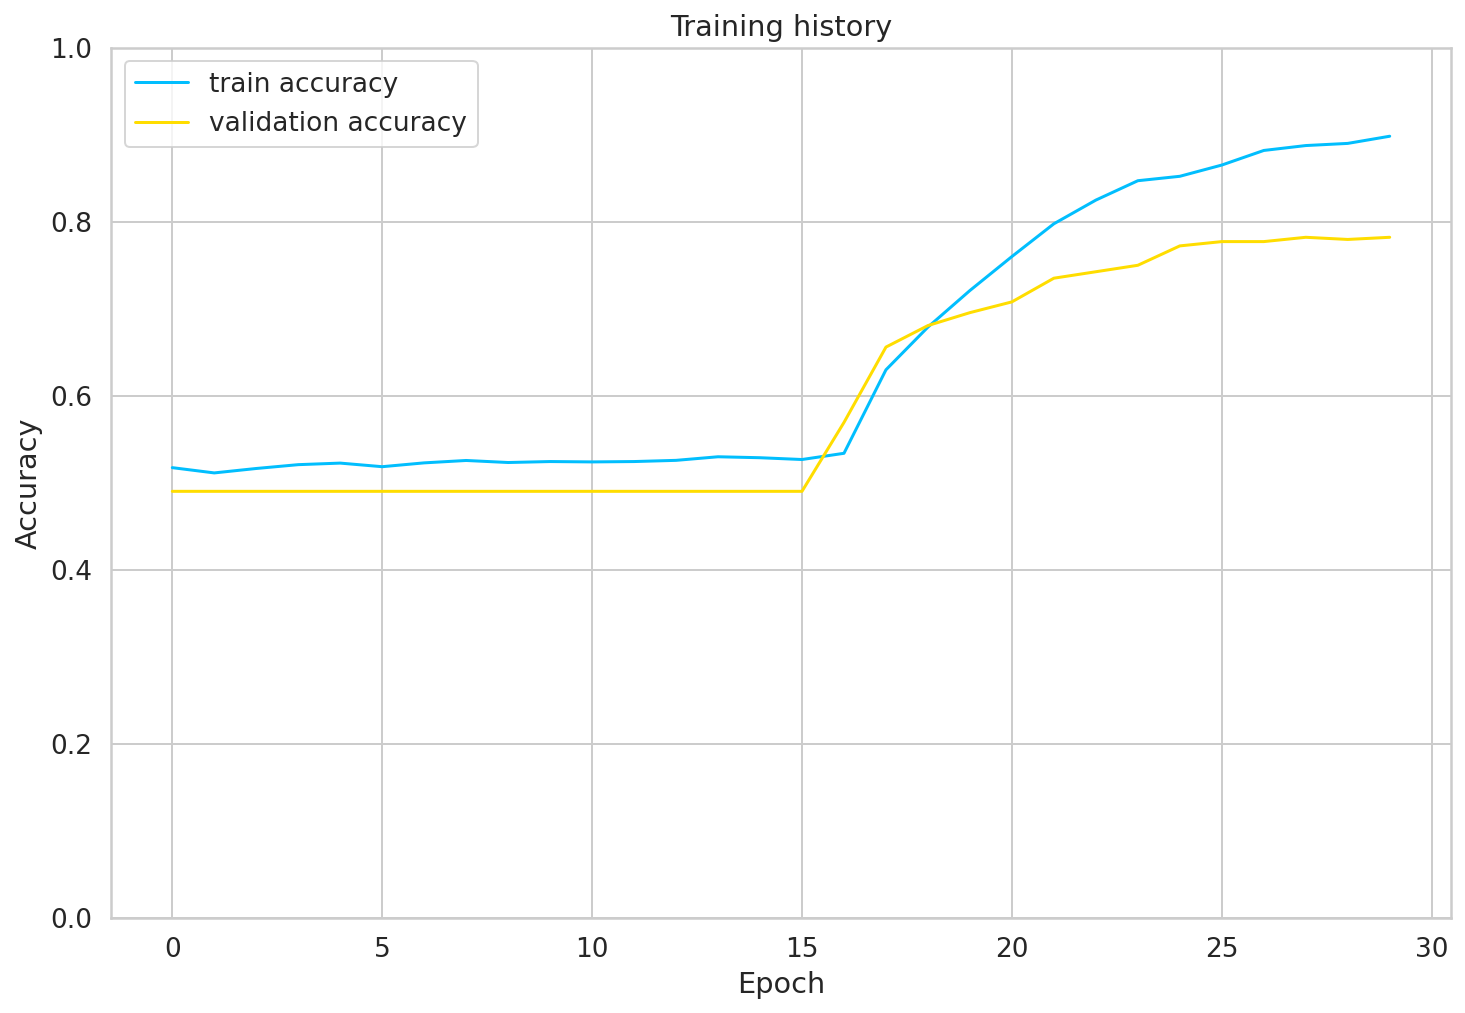

In [56]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [57]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

1.6691358024691358

In [58]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [59]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [60]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NAG       0.79      0.83      0.81       522
         OAG       0.48      0.47      0.48       218
         CAG       0.72      0.65      0.69       217

    accuracy                           0.71       957
   macro avg       0.66      0.65      0.66       957
weighted avg       0.70      0.71      0.70       957



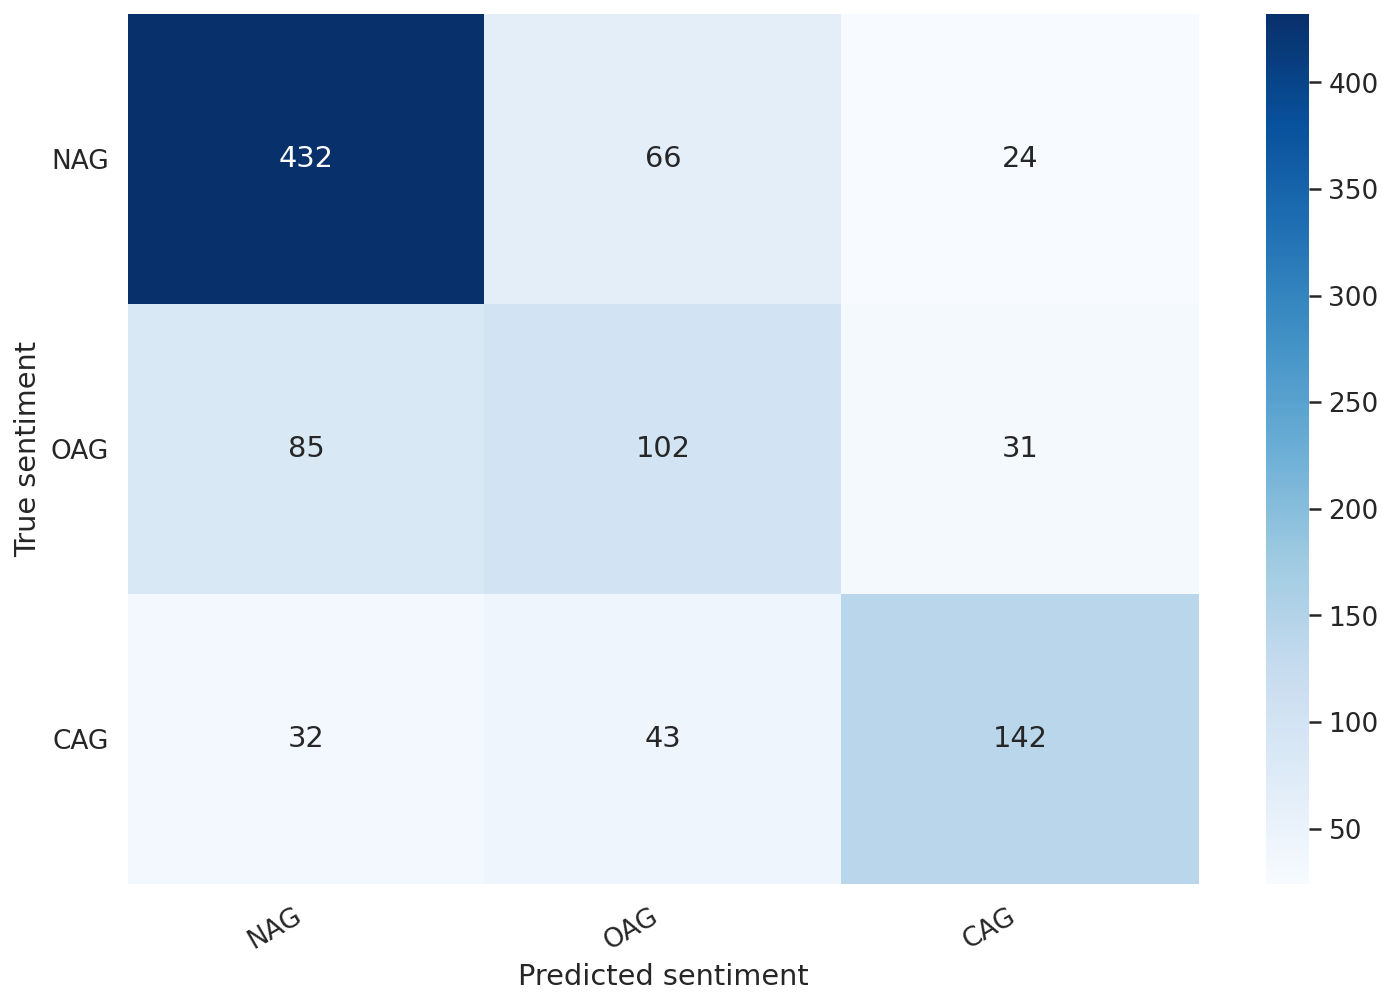

In [61]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [62]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [63]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Kadam thik dada

True sentiment: NAG


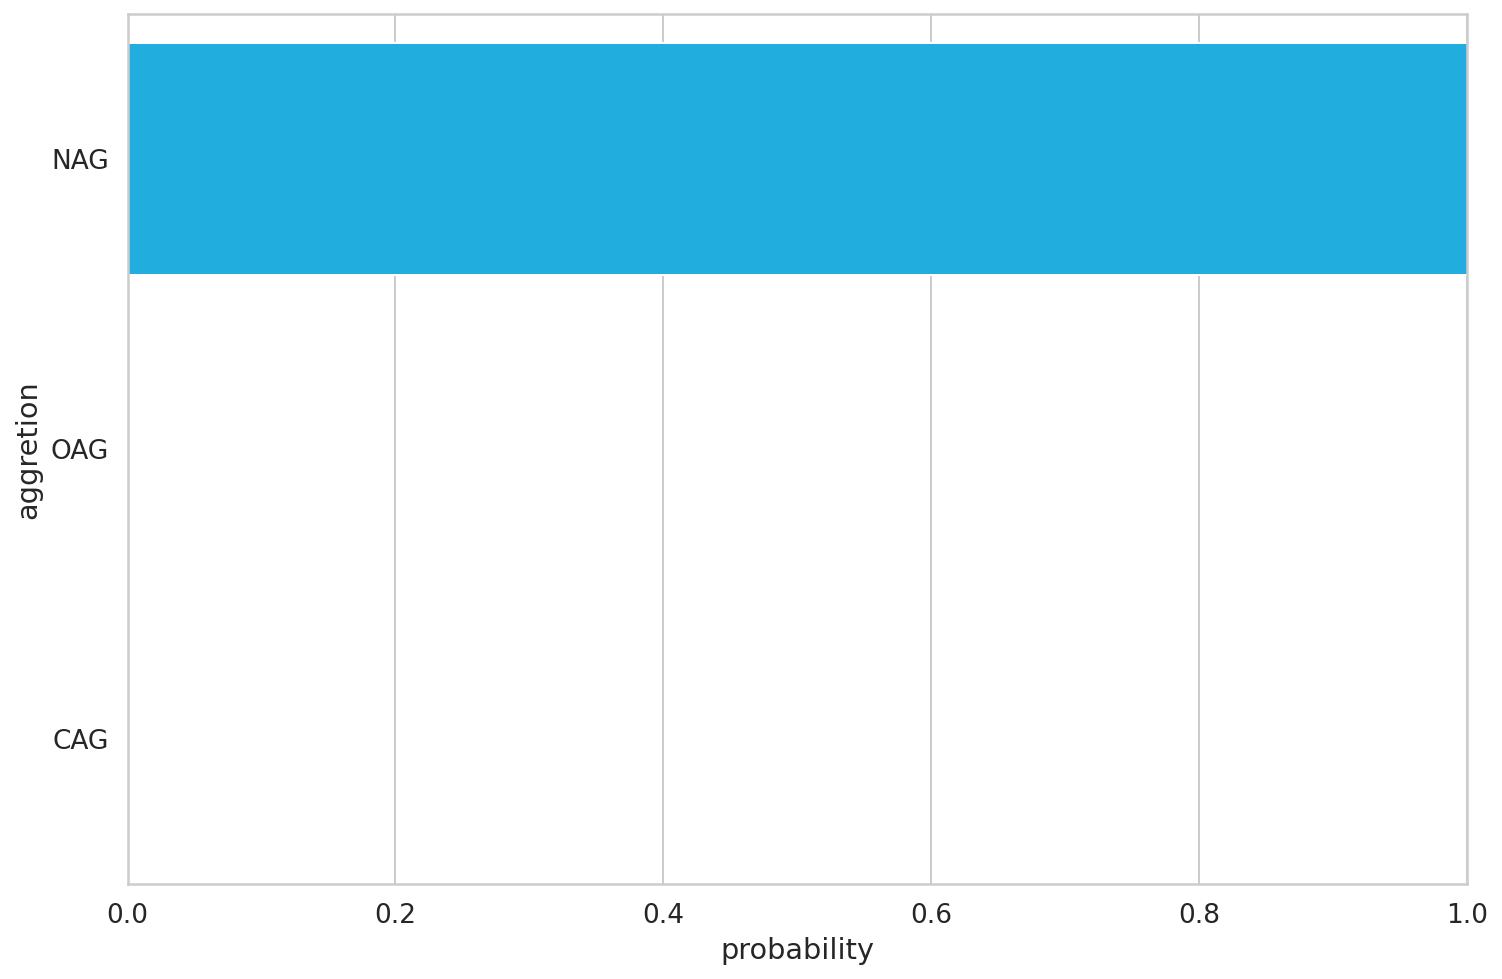

In [64]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('aggretion')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [65]:
review_text = "ছিঃ নির্লজ্জ বেহায়া কোথাকার ধিক্কার ছাড়া কিছুই রইল না"

In [66]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [67]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: ছিঃ নির্লজ্জ বেহায়া কোথাকার ধিক্কার ছাড়া কিছুই রইল না
Sentiment  : OAG
